Accuracy Metric
78.3080260304


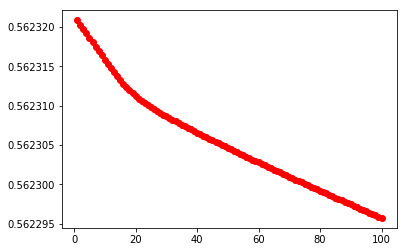

In [10]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 10 14:13:25 2017

@author: tjass
"""
import matplotlib.pyplot as plt
import numpy as np
import random

#We assume that all the array are column array (x,1)
with open("C:\\Users\\tjass\\Documents\\Parallelize\\spam.txt") as file:
    X_temp = [];
    Y_temp = [];
    for line in file:
        # The rstrip method gets rid of the "\n" at the end of each line
        line_split = line.rstrip().split(" ")
        X_temp.append(line_split[:len(line_split)-2]);
        Y_temp.append([line_split[-1]])

        
# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list();
    for i in range(len(dataset[0])):
        col_values = [float(row[i]) for row in dataset];
        value_min = min(col_values);
        value_max = max(col_values);
        minmax.append([value_min, value_max]);
    return minmax;

def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (float(row[i]) - minmax[i][0]) / (minmax[i][1] - minmax[i][0]);



minmax = dataset_minmax(X_temp)
normalize_dataset(X_temp,minmax)

X_tp = np.asarray(X_temp)
Y_tp = np.asarray(Y_temp)

## Split the data set into two parts: train and test

split_index = int(0.9*len(X_tp));
train_X = X_tp[:split_index];
train_Y = Y_tp[:split_index];
test_X = X_tp[split_index:];
test_Y = Y_tp[split_index:];



def sigma(z):
    if np.any(1/(1+np.exp(-z))>=0.5):
        return 1.
    else:
        return 0.       
        
def cost_function(y_estim,y,W,lambda_reg):
        summ=0.
        for m in range(0,len(y)):
            if y_estim[m][0]==0:
                summ = summ +(1.-float(y[m][0]))
            else:
                summ = summ + float(y[m][0])*np.log(y_estim[m][0]) + (1.-float(y[m][0]))*(1.-np.log(y_estim[m][0]))
        
        res = (1./len(y))*summ + (lambda_reg/(2.*len(y)))*np.sum(np.power(W,2))
        return res
#X est du type numpy array
def train(X,Y,iterations, learning_rate, lambda_reg):
    #Initialisation
    W = np.random.rand(56,1)
    b= random.random()
    cost=[]
    #Process
    for it in range(iterations):
        dW = np.zeros((57,1))
        y_estim = np.zeros((len(X),1))
        
        for k in range(0,len(W)):
            summ = 0.
            summ_b = 0.
            for m in range(0,len(X)):
                y_inter = np.dot(np.transpose(W),X[m])
                y_estim[m]=sigma(y_inter[0]+b)
                summ = summ + (y_estim[m] - float(Y[m][0]))*X[m,k]
                summ_b = summ_b + (y_estim[m] - float(Y[m][0]))
            dW[k]=(1./len(X))*summ+(lambda_reg/len(X))*W[k]
            W[k] = W[k] - learning_rate * dW[k]
        db=(1./len(X))*summ_b
        b= b-learning_rate*db
        res = cost_function(y_estim,Y,W,lambda_reg)
        cost.append(res)
    return (W,b,cost)

def predict(W,b,X):
    y_predict= np.zeros((len(X),1))
    for m in range(0,len(X)):
        y_inter = np.dot(np.transpose(W),X[m])
        y_predict[m]=sigma(y_inter[0]+b)
    return y_predict


def accuracy_metric(actual, predicted):
    correct = 0;
    for i in range(len(actual)):
        if float(actual[i][0]) == predicted[i][0]:
            correct += 1;
    return correct / float(len(actual)) * 100.0;


(W,b,cost) = train(train_X,train_Y,100,0.1,0.1)
y_predict = predict(W,b,test_X)
print("Accuracy Metric")
print(accuracy_metric(test_Y,y_predict))
plt.plot(range(1,len(cost)+1),cost,'ro')
plt.show()

# Now with Spark

In [1]:
'''
Everything parallel version 1
'''
from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

def sigma(z):
    if np.any(1/(1+np.exp(-z))>=0.5):
        return 1.
    else:
        return 0. 

def map_function(x,W,b):
    list_summ = []
    for i in range(0,len(x[0])):
        list_summ.append((sigma(np.dot(np.transpose(W),np.array(x[0]))+b)-float(x[1]))*x[0][i])
    list_summ.append(sigma(np.dot(np.transpose(W),np.array(x[0]))+b)-float(x[1]))
    return list(list_summ)

def map_function_cost(x,W,b):
    res = 0.0
    y_estim = sigma(np.dot(np.transpose(W),np.array(x[0]))+b)
    y = float(x[1])
    if y_estim == 0:
        res = 1-y
    else:
        res = y*np.log(y_estim)+(1-y)*(1-np.log(y_estim))
    return res
    
def reduce_function_cost(x,y):
    res2 = float(x)+float(y)
    return res2
    
def reduce_function(x,y):
    list_summ2 = []
    for i in range(0,len(x)):
        list_summ2.append(float(y[i])+float(x[i]))
    return list(list_summ2)

def train(df,iterations, learning_rate, lambda_reg):
    #Initialisation
    
    W = np.random.rand(56,1)    
    b = np.random.random()
    #Process
    list_cost = []
    for it in range(iterations):      
        rdd_predict = df.rdd.map(lambda x: map_function(x,W,b))
        m = rdd_predict.count()
        broadcastm = sc.broadcast(m)
        dW = [(1./m)*h for h in rdd_predict.reduce(reduce_function)]
        for i in range(0,len(dW)-1):
            dW[i] = dW[i] + (lambda_reg/m)*W[i]
            W[i] = W[i] - learning_rate * dW[i]
        broadcastW = sc.broadcast(W)
        db = dW[-1]
        b= b-learning_rate*db
        broadcastb = sc.broadcast(b)
        #tmp1 contain the sum
        cost = -(1/broadcastm.value)*df.rdd.map(lambda x: map_function_cost(x,broadcastW.value,broadcastb.value)).reduce(reduce_function_cost)+lambda_reg/((2.*broadcastm.value)*np.sum(np.power(W,2)))
        list_cost.append(cost)
    return (W,b,list_cost)

def predict(W,b,X):
    y_predict= np.zeros((len(X),1))
    for m in range(0,len(X)):
        y_inter = np.dot(np.transpose(W),X[m])
        y_predict[m]=sigma(y_inter[0]+b)
    return y_predict


def accuracy_metric(actual, predicted):
    correct = 0;
    for i in range(len(actual)):
        if float(actual[i]) == predicted[i]:
            correct += 1;
    return correct / float(len(actual)) * 100.0;

inputDF1 = spark.read.format("csv").option("delimiter"," ").load("C:\\Users\\tjass\\Documents\\Parallelize\\spam.txt").drop("_c56").withColumnRenamed("_c57","_c56")
#DF = inputDF1.select([inputDF1[c].cast("Double") for c in inputDF1.columns])

#Normalization
RDD_feature = inputDF1.rdd.map(lambda x: Vectors.dense(x[:len(x)-1]))
scaler1 = StandardScaler(withMean=True, withStd=True).fit(RDD_feature)

features = scaler1.transform(RDD_feature).flatMap(lambda x: Row(x.values.tolist())).zipWithIndex()
label = inputDF1.rdd.flatMap(lambda x : Row(str(x[len(x)-1]))).zipWithIndex()
df_label = label.toDF().withColumnRenamed("_1","label").withColumnRenamed("_2","index")
df_features = features.toDF().withColumnRenamed("_1","features").withColumnRenamed("_2","index")
df = df_features.join(df_label,df_features["index"]==df_label["index"]).drop("index")

(trainingdf, testdf) = df.randomSplit([0.9, 0.1])


(W,b,list_cost) = train(trainingdf,20,0.1,0.1)

X = testdf.rdd.map(lambda x: x[0]).collect()
Y = testdf.rdd.map(lambda x: float(x[1])).collect()

Y_predict = predict(W,b,X)
print("Accuracy Metric"+accuracy_metric(Y,Y_predict))
plt.plot(range(1,len(list_cost)+1),list_cost,'ro')
plt.show()

9.49481927634e-07
9.66444105705e-07
9.83381443287e-07
1.00027236227e-06
1.0171186072e-06
Accuracy Metric
60.4285714286


Accuracy Metric = 71.5899218071


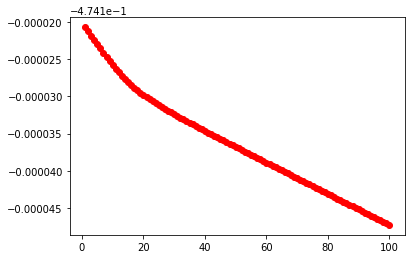

Time of execution: 1429.58518274


In [7]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 10 14:13:25 2017 

@author: tjass
Only Cost Functiun parallel
"""

import numpy as np
import random
import matplotlib.pyplot as plt
import timeit

start_time = timeit.default_timer()
#We assume that all the array are column array (x,1)
with open("C:\\Users\\tjass\\Documents\\Parallelize\\spam.txt") as file:
    X_temp = [];
    Y_temp = [];
    for line in file:
        # The rstrip method gets rid of the "\n" at the end of each line
        line_split = line.rstrip().split(" ")
        X_temp.append(line_split[:len(line_split)-2]);
        Y_temp.append([line_split[-1]])

        
# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list();
    for i in range(len(dataset[0])):
        col_values = [float(row[i]) for row in dataset];
        value_min = min(col_values);
        value_max = max(col_values);
        minmax.append([value_min, value_max]);
    return minmax;

def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (float(row[i]) - minmax[i][0]) / (minmax[i][1] - minmax[i][0]);



minmax = dataset_minmax(X_temp)
normalize_dataset(X_temp,minmax)

X_tp = np.asarray(X_temp)
Y_tp = np.asarray(Y_temp)

## Split the data set into two parts: train and test

split_index = int(0.75*len(X_tp));
train_X = X_tp[:split_index];
train_Y = Y_tp[:split_index];
test_X = X_tp[split_index:];
test_Y = Y_tp[split_index:];



def sigma(z):
    if np.any(1/(1+np.exp(-z))>=0.5):
        return 1.
    else:
        return 0.       
    
def map_cost(y):
    if(y[0]!=0):
        return y[1]*np.log(y[0])+(1-np.log(y[0]))*(1-y[1])
    else:
        return 1-y[1]

        
def cost_function(y_estim,W,lambda_reg):
        rdd = sc.parallelize(y_estim)
        rdd_w = sc.parallelize(W)
        m = rdd.count()
        res1 = rdd.map(lambda y: map_cost(y)).reduce(lambda x,y: x+y)
        res2 = rdd_w.reduce(lambda x,y: x+y)
        return -(1./m)*res1 + (lambda_reg/(2.*m))*res2

#X est du type numpy array
def train(X,Y,iterations, learning_rate, lambda_reg):
    #Initialisation
    cost=[]
    W = np.random.rand(56,1)
    b= random.random()
    #Process
    for it in range(iterations):
        dW = np.zeros((57,1))
        y_estim = np.zeros((len(X),2))
        for k in range(0,len(W)):
            summ = 0.
            summ_b = 0.
            for m in range(0,len(X)):
                y_inter = np.dot(np.transpose(W),X[m])
                y_estim[m][0]=sigma(y_inter[0]+b)
                y_estim[m][1]=float(Y[m][0])
                summ = summ + (y_estim[m][0] - float(Y[m][0]))*X[m,k]
                summ_b = summ_b + (y_estim[m][0] - float(Y[m][0]))
            dW[k]=(1./len(X))*summ+(lambda_reg/len(X))*W[k]
            W[k] = W[k] - learning_rate * dW[k]
        db=(1./len(X))*summ_b
        b= b-learning_rate*db
        cost.append(cost_function(y_estim,W,lambda_reg)[0])
    return (W,b,cost)

def predict(W,b,X):
    y_predict= np.zeros((len(X),1))
    for m in range(0,len(X)):
        y_inter = np.dot(np.transpose(W),X[m])
        y_predict[m]=sigma(y_inter[0]+b)
    return y_predict


def accuracy_metric(actual, predicted):
    correct = 0;
    for i in range(len(actual)):
        if float(actual[i][0]) == predicted[i][0]:
            correct += 1;
    return correct / float(len(actual)) * 100.0;


(W,b,cost) = train(train_X,train_Y,100,0.1,0.1)
y_predict = predict(W,b,test_X)
print("Accuracy Metric = " + str(accuracy_metric(test_Y,y_predict)))

plt.plot(range(1,len(cost)+1),cost,'ro')
plt.show()

elapsed = timeit.default_timer() - start_time
print("Time of execution: " + str(elapsed))

Accuracy Metric = 56.9868995633


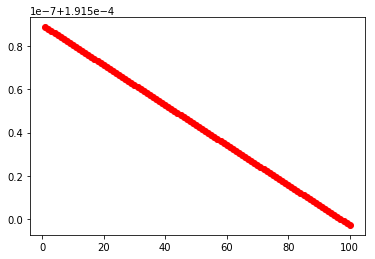

Time of execution: 611.673265485


In [6]:
'''
Everything parallel version 2
'''

from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import timeit



def sigma(z):
    if np.any(1/(1+np.exp(-z))>=0.5):
        return 1.
    else:
        return 0. 

def map_function(x,W,b):
    #x is a tuple ([x1, ..., xk],label)
    list_summ = []
    y_hat = sigma(np.dot(x[0],W)+b)
    for i in range(0,len(x[0])):
        list_summ.append((y_hat-x[1])*x[0][i])
    list_summ.append((y_hat-x[1]))
    return list(list_summ)

def map_cost(x,W,b):
    y_hat = sigma(np.dot(x[0],W)+b)
    return pow(y_hat-x[1],2)
    
def reduce_cost(x,y):
    return x+y
    
def reduce_function(x,y):
    list_summ2 = []
    for i in range(0,len(x)):
        list_summ2.append(y[i]+x[i])
    return list(list_summ2)

def train(rdd,iterations, learning_rate, lambda_reg):
    #Initialisation
    
    W = np.random.rand(56,1)    
    b = np.random.random()
    m = rdd.count()
    #Process
    list_cost = []
    for it in range(iterations):      
        dW_inter = rdd.map(lambda x: map_function(x,W,b)).reduce(reduce_function)
        dW = [(1/m)*i for i in dW_inter]
        for i in range(0,len(dW)-1):
            dW[i] = dW[i] + (lambda_reg/m)*W[i]
            W[i] = W[i] - learning_rate * dW[i]
        db = dW[-1]
        b = b-learning_rate*db
        broadcastb = sc.broadcast(b)
        broadcastW = sc.broadcast(W)
        cost_inter = (1/(2*m))*rdd.map(lambda x: map_cost(x,broadcastW.value,broadcastb.value)).reduce(reduce_cost)
        cost = cost_inter + (lambda_reg/(2.*m))*np.sum(np.power(W,2))
        list_cost.append(cost)    
    return (W,b,list_cost)
    

def predict(W,b,X):
    y_predict = np.zeros((len(X),1))
    for m in range(0,len(X)):
        y_inter = np.dot(X[m],W)
        y_predict[m] = sigma(y_inter+b)
    return y_predict


def accuracy_metric(actual, predicted):
    correct = 0;
    for i in range(len(actual)):
        if float(actual[i]) == predicted[i]:
            correct += 1;
    return correct / float(len(actual)) * 100.0;

start_time = timeit.default_timer()
inputDF1 = spark.read.format("csv").option("delimiter"," ").load("C:\\Users\\tjass\\Documents\\Parallelize\\spam.txt").drop("_c56").withColumnRenamed("_c57","_c56")
#DF = inputDF1.select([inputDF1[c].cast("Double") for c in inputDF1.columns])

#Normalization
RDD_feature = inputDF1.rdd.map(lambda x: Vectors.dense(x[:len(x)-1]))
scaler1 = StandardScaler(withMean=True, withStd=True).fit(RDD_feature)

features = scaler1.transform(RDD_feature).map(lambda x: x.tolist())
label = inputDF1.rdd.map(lambda x : float(x[len(x)-1]))

RDD_norm = features.zip(label)
#RDD_norm : RDD(Tuple(list(float),float))

(trainRDD,testRDD) = RDD_norm.randomSplit([0.9,0.1])


(W,b,list_cost) = train(trainRDD,100,1,0.1)

X = np.array(testRDD.map(lambda x: x[0]).collect())
Y = np.array(testRDD.map(lambda x: x[1]).collect())
Y_predict = predict(W,b,X)

print("Accuracy Metric = "+str(accuracy_metric(Y,Y_predict)))
plt.plot(range(1,len(list_cost)+1),list_cost,'ro')
plt.show()

elapsed = timeit.default_timer() - start_time
print("Time of execution: " + str(elapsed))